In [1]:
! pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.7/190.7 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 8.6 MB/s eta 0:00:00


In [11]:
import deepxde as dde
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
# Material parameters for linear elasticity
lmbd = 1.0  # First Lamé parameter
mu = 0.5    # Second Lamé parameter (shear modulus)
gravity = 9.8  # Gravity magnitude applied in the negative Y direction
mass = 1.5
# Define geometry for a 3D beam (length=4, width=1, height=1)
geom = dde.geometry.Cuboid([0, 0, 0], [4, 1, 1])

In [ ]:
# Boundary condition functions
def boundary_fixed(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0.0)

def boundary_free(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 4.0)

# Fixed boundary at one end (ux=0, uy=0, uz=0)
bc_fixed_x = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_fixed, component=0)  # ux=0
bc_fixed_y = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_fixed, component=1)  # uy=0
bc_fixed_z = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_fixed, component=2)  # uz=0

import numpy as np

# Gravity force increasing step by step in the x-direction
def gravity_force(inputs, outputs, X):
    # Initialize force arrays
    force_x = -mass * np.ones_like(X[:, 0])  # pour se plier
    force_y = -gravity * np.ones_like(X[:, 1])  # Initial gravity in the negative y direction
    force_z = np.zeros_like(X[:, 2])  # No force in the z direction

    return np.stack([force_x, force_y, force_z], axis=1)


bc_gravity = dde.icbc.OperatorBC(geom, gravity_force, lambda x, _: True)  # Applies to all points

# Define the boundary conditions list
bc = [bc_fixed_x, bc_fixed_y, bc_fixed_z, bc_gravity]


In [ ]:
# Define PDE for 3D linear elasticity
def pde(X, u):
    ux, uy, uz = u[:, 0:1], u[:, 1:2], u[:, 2:3]

    # Strain components
    E_xx = dde.grad.jacobian(ux, X, j=0)  # d(ux)/dx
    E_yy = dde.grad.jacobian(uy, X, j=1)  # d(uy)/dy
    E_zz = dde.grad.jacobian(uz, X, j=2)  # d(uz)/dz

    # Shear strain components
    E_xy = 0.5 * (dde.grad.jacobian(ux, X, j=1) + dde.grad.jacobian(uy, X, j=0))
    E_xz = 0.5 * (dde.grad.jacobian(ux, X, j=2) + dde.grad.jacobian(uz, X, j=0))
    E_yz = 0.5 * (dde.grad.jacobian(uy, X, j=2) + dde.grad.jacobian(uz, X, j=1))

    # Stress components based on strain and material properties
    Sxx = E_xx * (2 * mu + lmbd) + (E_yy + E_zz) * lmbd
    Syy = E_yy * (2 * mu + lmbd) + (E_xx + E_zz) * lmbd
    Szz = E_zz * (2 * mu + lmbd) + (E_xx + E_yy) * lmbd
    Sxy = 2 * mu * E_xy
    Sxz = 2 * mu * E_xz
    Syz = 2 * mu * E_yz

    # Elasticity equilibrium equations
    eq_x = dde.grad.jacobian(Sxx, X, j=0) + dde.grad.jacobian(Sxy, X, j=1) + dde.grad.jacobian(Sxz, X, j=2)
    eq_y = dde.grad.jacobian(Sxy, X, j=0) + dde.grad.jacobian(Syy, X, j=1) + dde.grad.jacobian(Syz, X, j=2)
    eq_z = dde.grad.jacobian(Sxz, X, j=0) + dde.grad.jacobian(Syz, X, j=1) + dde.grad.jacobian(Szz, X, j=2)

    return [eq_x, eq_y, eq_z]


In [9]:
# Visualization function to show the displacement
def plot_displacement(model):
    # Create a grid of points in the beam
    x = np.linspace(0, 4, 40)
    y = np.linspace(0, 1, 10)
    z = np.linspace(0, 1, 10)
    X, Y, Z = np.meshgrid(x, y, z)
    points = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T

    # Predict displacements
    u_pred = model.predict(points)[:, :3]

    # Plotting predicted displacement
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.quiver(points[:, 0], points[:, 1], points[:, 2],
              u_pred[:, 0], u_pred[:, 1], u_pred[:, 2], color="blue")
    ax.set_title("Predicted Displacement Field (Blue)")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()

In [ ]:

# Material parameters for linear elasticity
lmbd = 1.0  # First Lamé parameter
mu = 0.5    # Second Lamé parameter (shear modulus)
gravity = 9.8  # Gravity magnitude applied in the negative Y direction
mass = 10.5

# Define geometry for a 3D beam (length=4, width=1, height=1)
geom = dde.geometry.Cuboid([0, 0, 0], [4, 1, 1])

# Boundary condition functions
def boundary_fixed(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0.0)

# Fixed boundary at one end (ux=0, uy=0, uz=0)
bc_fixed_x = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_fixed, component=0)  # ux=0
bc_fixed_y = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_fixed, component=1)  # uy=0
bc_fixed_z = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_fixed, component=2)  # uz=0

# Gravity force increasing in the y-direction
def gravity_force(inputs, outputs, X):
    force_x =  mass*np.ones_like(X[:, 0])  # No force in x-direction
    force_y = -gravity  * np.ones_like(X[:, 1])  # Gravity in the negative y-direction
    force_z = np.zeros_like(X[:, 2])  # No force in z-direction
    return np.stack([force_x, force_y, force_z], axis=1)

bc_gravity = dde.icbc.OperatorBC(geom, gravity_force, lambda x, _: True)  # Applies to all points

# Define the boundary conditions list
bc = [bc_fixed_x, bc_fixed_y, bc_fixed_z, bc_gravity]


In [ ]:

# Define the model
data = dde.data.PDE(geom, pde, bc, num_domain=4000, num_boundary=1000)
net = dde.maps.FNN([3] + [50] * 3 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)

# Train the model
model.compile("adam", lr=1e-4)
model.train(epochs=10000)


Compiling model...
Building feed-forward neural network...
'build' took 0.059433 s

'compile' took 2.672353 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [3.31e-02, 3.43e-02, 2.93e-02, 1.36e-01, 8.31e-03, 5.03e-03, 6.88e+01]    [3.31e-02, 3.43e-02, 2.93e-02, 1.36e-01, 8.31e-03, 5.03e-03, 6.88e+01]    []  
1000      [3.93e-05, 2.76e-05, 2.57e-05, 1.06e-05, 8.44e-07, 3.30e-07, 6.88e+01]    [3.93e-05, 2.76e-05, 2.57e-05, 1.06e-05, 8.44e-07, 3.30e-07, 6.88e+01]    []  
2000      [1.35e-05, 7.56e-06, 6.80e-06, 6.63e-06, 3.98e-07, 1.94e-07, 6.88e+01]    [1.35e-05, 7.56e-06, 6.80e-06, 6.63e-06, 3.98e-07, 1.94e-07, 6.88e+01]    []  
3000      [4.99e-06, 3.42e-06, 3.38e-06, 3.99e-06, 3.79e-07, 1.67e-07, 6.88e+01]    [4.99e-06, 3.42e-06, 3.38e-06, 3.99e-06, 3.79e-07, 1.67e-07, 6.88e+01]    []  
4000      [2.06e-06, 2.16e-06, 1.74e-06, 2.44e-0

(<deepxde.model.LossHistory at 0x7d2ac15795a0>,
 <deepxde.model.TrainState at 0x7d2ac157bd30>)

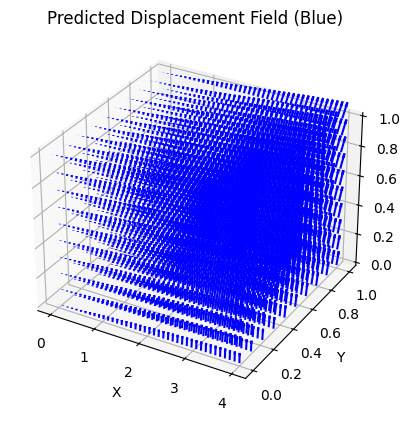

In [ ]:
# Call the plotting function
plot_displacement(model)

In [ ]:
import numpy as np
import plotly.graph_objects as go

def plot_displacement_plotly(model):
    # Create a grid of points in the beam
    x = np.linspace(0, 4, 40)
    y = np.linspace(0, 1, 10)
    z = np.linspace(0, 1, 10)
    X, Y, Z = np.meshgrid(x, y, z)
    points = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T

    # Predict displacements
    u_pred = model.predict(points)[:, :3]
    displaced_points = points + u_pred

    # Create Scatter3d for the original grid points
    scatter_original = go.Scatter3d(
        x=points[:, 0],
        y=points[:, 1],
        z=points[:, 2],
        mode='markers',
        marker=dict(size=2, color='blue'),
        name='Original Points'
    )

    # Create Scatter3d for the displaced grid points
    scatter_displaced = go.Scatter3d(
        x=displaced_points[:, 0],
        y=displaced_points[:, 1],
        z=displaced_points[:, 2],
        mode='markers',
        marker=dict(size=2, color='red'),
        name='Displaced Points'
    )

    # Configure the layout
    layout = go.Layout(
        title='3D Predicted Displacement Field',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data'
        ),
        legend=dict(x=0.7, y=0.95)
    )

    # Create the figure and add Scatter3d traces
    fig = go.Figure(data=[scatter_original, scatter_displaced], layout=layout)
    fig.show()

# Call the plotting function
plot_displacement_plotly(model)


In [41]:
import deepxde as dde
import numpy as np
import tensorflow as tf

# Material properties
E = 2e9  # Young's modulus (Pa)
nu = 0.3  # Poisson's ratio
mu = E / (2 * (1 + nu))  # Shear modulus
lmbd = E * nu / ((1 + nu) * (1 - 2 * nu))  # Lamé's first parameter

# Beam dimensions and applied force
L = 6  # Length of the beam (m)
F = 1e2  # Force magnitude applied at the free end (N)

# Geometry: A rectangular beam
geom = dde.geometry.Cuboid([0,0, 0], [L, 1, 1])

# Define a distributed force applied at x=L (free end of the beam)
def force(X):
    # Apply a force only at the free end (x = L)
    return tf.where(
        tf.math.abs(X[:, 0:1] - L) < 1e-6,
        tf.constant([[0.0, F, 0.0]]),  # Force vector (x=0, y=F, z=0)
        tf.zeros_like(X)
    )


# PDE for 3D elasticity
def pde(X, u):
    ux, uy, uz = u[:, 0:1], u[:, 1:2], u[:, 2:3]

    # Strain components
    E_xx = dde.grad.jacobian(ux, X, j=0)  # d(ux)/dx
    E_yy = dde.grad.jacobian(uy, X, j=1)  # d(uy)/dy
    E_zz = dde.grad.jacobian(uz, X, j=2)  # d(uz)/dz

    # Shear strain components
    E_xy = 0.5 * (dde.grad.jacobian(ux, X, j=1) + dde.grad.jacobian(uy, X, j=0))
    E_xz = 0.5 * (dde.grad.jacobian(ux, X, j=2) + dde.grad.jacobian(uz, X, j=0))
    E_yz = 0.5 * (dde.grad.jacobian(uy, X, j=2) + dde.grad.jacobian(uz, X, j=1))

    # Stress components based on strain and material properties
    Sxx = E_xx * (2 * mu + lmbd) + (E_yy + E_zz) * lmbd
    Syy = E_yy * (2 * mu + lmbd) + (E_xx + E_zz) * lmbd
    Szz = E_zz * (2 * mu + lmbd) + (E_xx + E_yy) * lmbd
    Sxy = 2 * mu * E_xy
    Sxz = 2 * mu * E_xz
    Syz = 2 * mu * E_yz

    # Elasticity equilibrium equations (scale these terms)
    eq_x = (
        dde.grad.jacobian(Sxx, X, j=0)
        + dde.grad.jacobian(Sxy, X, j=1)
        + dde.grad.jacobian(Sxz, X, j=2)
        + force(X)[:, 0:1]
    ) / 1e6  # Scaling factor
    eq_y = (
        dde.grad.jacobian(Sxy, X, j=0)
        + dde.grad.jacobian(Syy, X, j=1)
        + dde.grad.jacobian(Syz, X, j=2)
        + force(X)[:, 1:2]
    ) / 1e6  # Scaling factor
    eq_z = (
        dde.grad.jacobian(Sxz, X, j=0)
        + dde.grad.jacobian(Syz, X, j=1)
        + dde.grad.jacobian(Szz, X, j=2)
        + force(X)[:, 2:3]
    ) / 1e6  # Scaling factor

    return [eq_x, eq_y, eq_z]

# Boundary conditions
def boundary(x, on_boundary):
    # Fix the end of the beam at x = 0 (all displacements are zero)
    return on_boundary and np.isclose(x[0], 0)

bc = dde.DirichletBC(geom, lambda x: [0, 0, 0], boundary)  # Fixed end at x=0
# Fixed boundary at one end (ux=0, uy=0, uz=0)
bc_fixed_x = dde.icbc.DirichletBC(geom, lambda x: 0, boundary, component=0)  # ux=0
bc_fixed_y = dde.icbc.DirichletBC(geom, lambda x: 0, boundary, component=1)  # uy=0
bc_fixed_z = dde.icbc.DirichletBC(geom, lambda x: 0, boundary, component=2)  # uz=0
bc = [bc_fixed_x, bc_fixed_y, bc_fixed_z]


# Define the model
data = dde.data.PDE(geom, pde,bc, num_domain=4000, num_boundary=1000)
net = dde.maps.FNN([3] + [50] * 3 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)

# Train the model
model.compile("adam", lr=1e-4)
model.train(epochs=10000)




Compiling model...
Building feed-forward neural network...
'build' took 0.054546 s

'compile' took 3.817347 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [3.20e+03, 2.59e+04, 3.46e+04, 1.32e-02, 3.70e-02, 5.90e-02]    [3.20e+03, 2.59e+04, 3.46e+04, 1.32e-02, 3.70e-02, 5.90e-02]    []  
1000      [2.46e+01, 9.90e+00, 4.04e+01, 1.16e-03, 2.23e-03, 5.06e-03]    [2.46e+01, 9.90e+00, 4.04e+01, 1.16e-03, 2.23e-03, 5.06e-03]    []  
2000      [5.21e+00, 3.70e+00, 1.16e+01, 7.58e-04, 9.49e-04, 3.00e-03]    [5.21e+00, 3.70e+00, 1.16e+01, 7.58e-04, 9.49e-04, 3.00e-03]    []  
3000      [2.74e+00, 1.66e+00, 4.37e+00, 5.80e-04, 5.17e-04, 1.92e-03]    [2.74e+00, 1.66e+00, 4.37e+00, 5.80e-04, 5.17e-04, 1.92e-03]    []  
4000      [1.77e+00, 7.08e-01, 1.90e+00, 4.71e-04, 3.11e-04, 1.34e-03]    [1.77e+00, 7.08e-01, 1.90e+00, 4.71e-04, 3.11e-04, 1.34e-03]    []  
5000 

(<deepxde.model.LossHistory at 0x79073e0b6860>,
 <deepxde.model.TrainState at 0x79073e0b7850>)

In [42]:
import numpy as np
import plotly.graph_objects as go

def plot_displacement_plotly(model):
    # Create a grid of points in the beam
    x = np.linspace(0, 4, 40)
    y = np.linspace(0, 1, 10)
    z = np.linspace(0, 1, 10)
    X, Y, Z = np.meshgrid(x, y, z)
    points = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T

    # Predict displacements
    u_pred = model.predict(points)[:, :3]
    displaced_points = points + u_pred

    # Create Scatter3d for the original grid points
    scatter_original = go.Scatter3d(
        x=points[:, 0],
        y=points[:, 1],
        z=points[:, 2],
        mode='markers',
        marker=dict(size=2, color='blue'),
        name='Original Points'
    )

    # Create Scatter3d for the displaced grid points
    scatter_displaced = go.Scatter3d(
        x=displaced_points[:, 0],
        y=displaced_points[:, 1],
        z=displaced_points[:, 2],
        mode='markers',
        marker=dict(size=2, color='red'),
        name='Displaced Points'
    )

    # Configure the layout
    layout = go.Layout(
        title='3D Predicted Displacement Field',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data'
        ),
        legend=dict(x=0.7, y=0.95)
    )

    # Create the figure and add Scatter3d traces
    fig = go.Figure(data=[scatter_original, scatter_displaced], layout=layout)
    fig.show()

# Call the plotting function
plot_displacement_plotly(model)


In [43]:
import numpy as np
import plotly.graph_objects as go

def plot_displacement_plotly(model):
    # Create a grid of points in the beam
    x = np.linspace(0, 4, 20)  # Reduce resolution for better rendering
    y = np.linspace(0, 1, 10)
    z = np.linspace(0, 1, 10)
    X, Y, Z = np.meshgrid(x, y, z)
    points = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T

    # Predict displacements
    u_pred = model.predict(points)[:, :3]
    displaced_points = points + u_pred

    # Extract coordinates of displaced points
    x_displaced = displaced_points[:, 0]
    y_displaced = displaced_points[:, 1]
    z_displaced = displaced_points[:, 2]

    # Create the mesh for the original beam (optional for comparison)
    mesh_original = go.Mesh3d(
        x=points[:, 0],
        y=points[:, 1],
        z=points[:, 2],
        color='blue',
        opacity=0.5,
        name='Original Beam'
    )

    # Create the mesh for the displaced beam
    mesh_displaced = go.Mesh3d(
        x=x_displaced,
        y=y_displaced,
        z=z_displaced,
        color='red',
        opacity=0.7,
        name='Displaced Beam'
    )

    # Configure the layout
    layout = go.Layout(
        title='3D Predicted Displacement Field (Continuous Beam)',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data'
        ),
        legend=dict(x=0.7, y=0.95)
    )

    # Create the figure and add Mesh3d traces
    fig = go.Figure(data=[mesh_original, mesh_displaced], layout=layout)
    fig.show()

# Call the plotting function
plot_displacement_plotly(model)
